### Import Libraries

In [1]:
import tensorflow as tf
import tensorflow_hub as hub

import PIL.Image as Image
import matplotlib.pylab as plt

import numpy as np
import cv2

# Pretrained Classifier Model

### ImageNet Classifier

In [2]:
inception_v3 = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"
classifier_model = inception_v3

In [4]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,))
])

### Prediction on Single Image

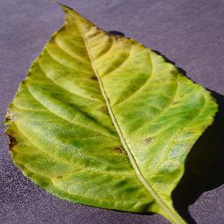

In [5]:
Test_Image_URL=r'C:\Users\USER\Documents\Machine Learning\Multi-plant-disease-ML\multi-plant-disease-dataset\Pepper__bell___Bacterial_spot\0d8421cd-eebc-4018-b591-12352dd970a7___JR_B.Spot 3234.JPG'
Test_Image = Image.open(Test_Image_URL).resize(IMAGE_SHAPE)
Test_Image

In [6]:
Test_Image_Object = np.array(Test_Image)/255.0
Test_Image_Object.shape
Test_Image_Object[:3]

array([[[0.49803922, 0.4627451 , 0.56862745],
        [0.50588235, 0.47058824, 0.57647059],
        [0.50196078, 0.46666667, 0.57254902],
        ...,
        [0.42352941, 0.36862745, 0.46666667],
        [0.42745098, 0.37254902, 0.47058824],
        [0.42745098, 0.37254902, 0.47058824]],

       [[0.49019608, 0.45490196, 0.56078431],
        [0.49411765, 0.45882353, 0.56470588],
        [0.49411765, 0.45882353, 0.56470588],
        ...,
        [0.4       , 0.34509804, 0.44313725],
        [0.41176471, 0.35686275, 0.45490196],
        [0.41176471, 0.35686275, 0.45490196]],

       [[0.49019608, 0.45490196, 0.56078431],
        [0.49411765, 0.45882353, 0.56470588],
        [0.49411765, 0.45882353, 0.56470588],
        ...,
        [0.39607843, 0.34117647, 0.43921569],
        [0.40784314, 0.35294118, 0.45098039],
        [0.41960784, 0.36470588, 0.4627451 ]]])

In [7]:
result = classifier.predict(Test_Image_Object[np.newaxis, ...])
result

1/1 [==============================] - 1s 1s/step


array([[-0.13903543,  1.2706212 ,  0.9802443 , ...,  1.6007762 ,
         1.5004929 , -1.701616  ]], dtype=float32)

In [8]:
predicted_class = tf.math.argmax(result[0], axis=-1)
predicted_class

<tf.Tensor: shape=(), dtype=int64, numpy=937>

ImageNet Labels

In [9]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())
print("ImageNet labels: ")
print(imagenet_labels)
print("\nNumber of Labels: ")
print(imagenet_labels.shape)

ImageNet labels: 
['background' 'tench' 'goldfish' ... 'bolete' 'ear' 'toilet tissue']

Number of Labels: 
(1001,)


Predicted Output

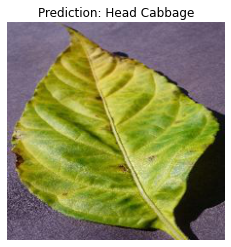

In [10]:
plt.imshow(Test_Image_Object)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

# Training Process

### Dataset Process

In [11]:
dataset_root = "multi-plant-disease-dataset"

#### Constents

In [12]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224

#### Spliting Dataset

In [13]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  str(dataset_root),
  validation_split=0.3,
  subset="training",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE
)

Found 20637 files belonging to 15 classes.
Using 14446 files for training.


In [14]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  str(dataset_root),
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE
)

Found 20637 files belonging to 15 classes.
Using 6191 files for validation.


In [15]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

In [16]:
print("Train data batch size", len(train_ds))
print("Validation data batch size", len(val_ds))
print("Test data batch size", len(test_ds))

Train data batch size 452
Validation data batch size 156
Test data batch size 38


### Classes

In [17]:
class_names = np.array(train_ds.class_names)
print(class_names)

['Pepper__bell___Bacterial_spot' 'Pepper__bell___healthy'
 'Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy'
 'Tomato_Bacterial_spot' 'Tomato_Early_blight' 'Tomato_Late_blight'
 'Tomato_Leaf_Mold' 'Tomato_Septoria_leaf_spot'
 'Tomato_Spider_mites_Two_spotted_spider_mite' 'Tomato__Target_Spot'
 'Tomato__Tomato_YellowLeaf__Curl_Virus' 'Tomato__Tomato_mosaic_virus'
 'Tomato_healthy']


In [18]:
print("Number of classes", len(class_names))

Number of classes 15


### Rescaling
Because TensorFlow Hub's convention for image models is to expect float inputs in the [0, 1] range, use the tf.keras.layers.Rescaling preprocessing layer to achieve this.

In [19]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

### Caching
input pipeline by using buffered prefetching with Dataset.prefetch, so you can yield the data from disk without I/O blocking issues.

In [20]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Train image batch and label batch


In [21]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


### Running Pretrained Classifier on Batch

In [22]:
result_batch = classifier.predict(train_ds)

452/452 [==============================] - 593s 1s/step


In [24]:
predicted_class_names = imagenet_labels[tf.math.argmax(result_batch, axis=-1)]
predicted_class_names

array(['sleeping bag', 'pot', 'buckeye', ..., 'head cabbage', 'buckeye',
       'common iguana'], dtype='<U30')

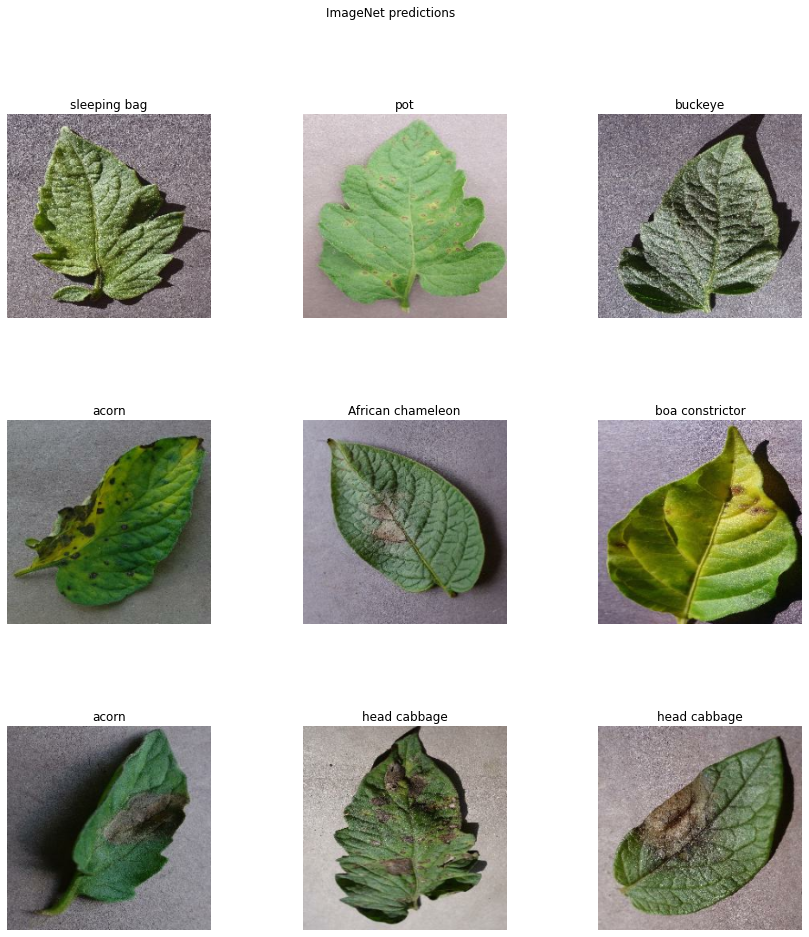

In [25]:
plt.figure(figsize=(15,15))
plt.subplots_adjust(hspace=0.5)
for n in range(9):
  plt.subplot(3,3,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

## Own Model Training

#### Headless model Download

In [29]:
inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
feature_extractor_model = inception_v3

Create the feature extractor by wrapping the pre-trained model as a Keras layer with hub.KerasLayer. Use the trainable=False argument to freeze the variables, so that the training only modifies the new classifier layer:

In [30]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False)

The feature extractor returns a 1280-long vector for each image (the image batch size remains at 32 in this example):

In [31]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 2048)


#### Attach a classification head

In [32]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 2048)              21802784  
                                                                 
 dense (Dense)               (None, 15)                30735     
                                                                 
Total params: 21,833,519
Trainable params: 30,735
Non-trainable params: 21,802,784
_________________________________________________________________


In [33]:
predictions = model(image_batch)
predictions.shape

TensorShape([32, 15])

#### Model Training

In [34]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

In [35]:
NUM_EPOCHS = 10

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS)

Epoch 1/10
452/452 [==============================] - 1326s 3s/step - loss: 0.9316 - acc: 0.7057 - val_loss: 0.6584 - val_acc: 0.7847
Epoch 2/10
452/452 [==============================] - 1298s 3s/step - loss: 0.5268 - acc: 0.8297 - val_loss: 0.5461 - val_acc: 0.8191
Epoch 3/10
452/452 [==============================] - 1259s 3s/step - loss: 0.4261 - acc: 0.8614 - val_loss: 0.4922 - val_acc: 0.8354
Epoch 4/10
452/452 [==============================] - 713s 2s/step - loss: 0.3657 - acc: 0.8816 - val_loss: 0.4601 - val_acc: 0.8442
Epoch 5/10
452/452 [==============================] - 729s 2s/step - loss: 0.3229 - acc: 0.8966 - val_loss: 0.4404 - val_acc: 0.8505
Epoch 6/10
452/452 [==============================] - 730s 2s/step - loss: 0.2898 - acc: 0.9074 - val_loss: 0.4282 - val_acc: 0.8543
Epoch 7/10
452/452 [==============================] - 721s 2s/step - loss: 0.2629 - acc: 0.9171 - val_loss: 0.4201 - val_acc: 0.8571
Epoch 8/10
452/452 [==============================] - 718s 2s/step

### Check Predictions

In [36]:
predicted_batch = model.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
print(predicted_label_batch)

1/1 [==============================] - 3s 3s/step
['Tomato_healthy' 'Tomato_Septoria_leaf_spot' 'Tomato_healthy'
 'Tomato_Early_blight' 'Potato___Late_blight'
 'Pepper__bell___Bacterial_spot' 'Tomato_Late_blight'
 'Tomato_Septoria_leaf_spot' 'Potato___Late_blight'
 'Tomato_Spider_mites_Two_spotted_spider_mite' 'Tomato_Septoria_leaf_spot'
 'Tomato_Leaf_Mold' 'Tomato_Bacterial_spot' 'Potato___Late_blight'
 'Potato___Late_blight' 'Tomato_Bacterial_spot' 'Tomato_Bacterial_spot'
 'Tomato_Septoria_leaf_spot' 'Tomato_Spider_mites_Two_spotted_spider_mite'
 'Tomato_Spider_mites_Two_spotted_spider_mite' 'Tomato_healthy'
 'Tomato_healthy' 'Potato___Early_blight' 'Potato___Early_blight'
 'Tomato_healthy' 'Tomato_Early_blight' 'Tomato_Bacterial_spot'
 'Potato___Early_blight' 'Tomato_Septoria_leaf_spot'
 'Tomato__Tomato_YellowLeaf__Curl_Virus' 'Potato___Early_blight'
 'Tomato_Leaf_Mold']


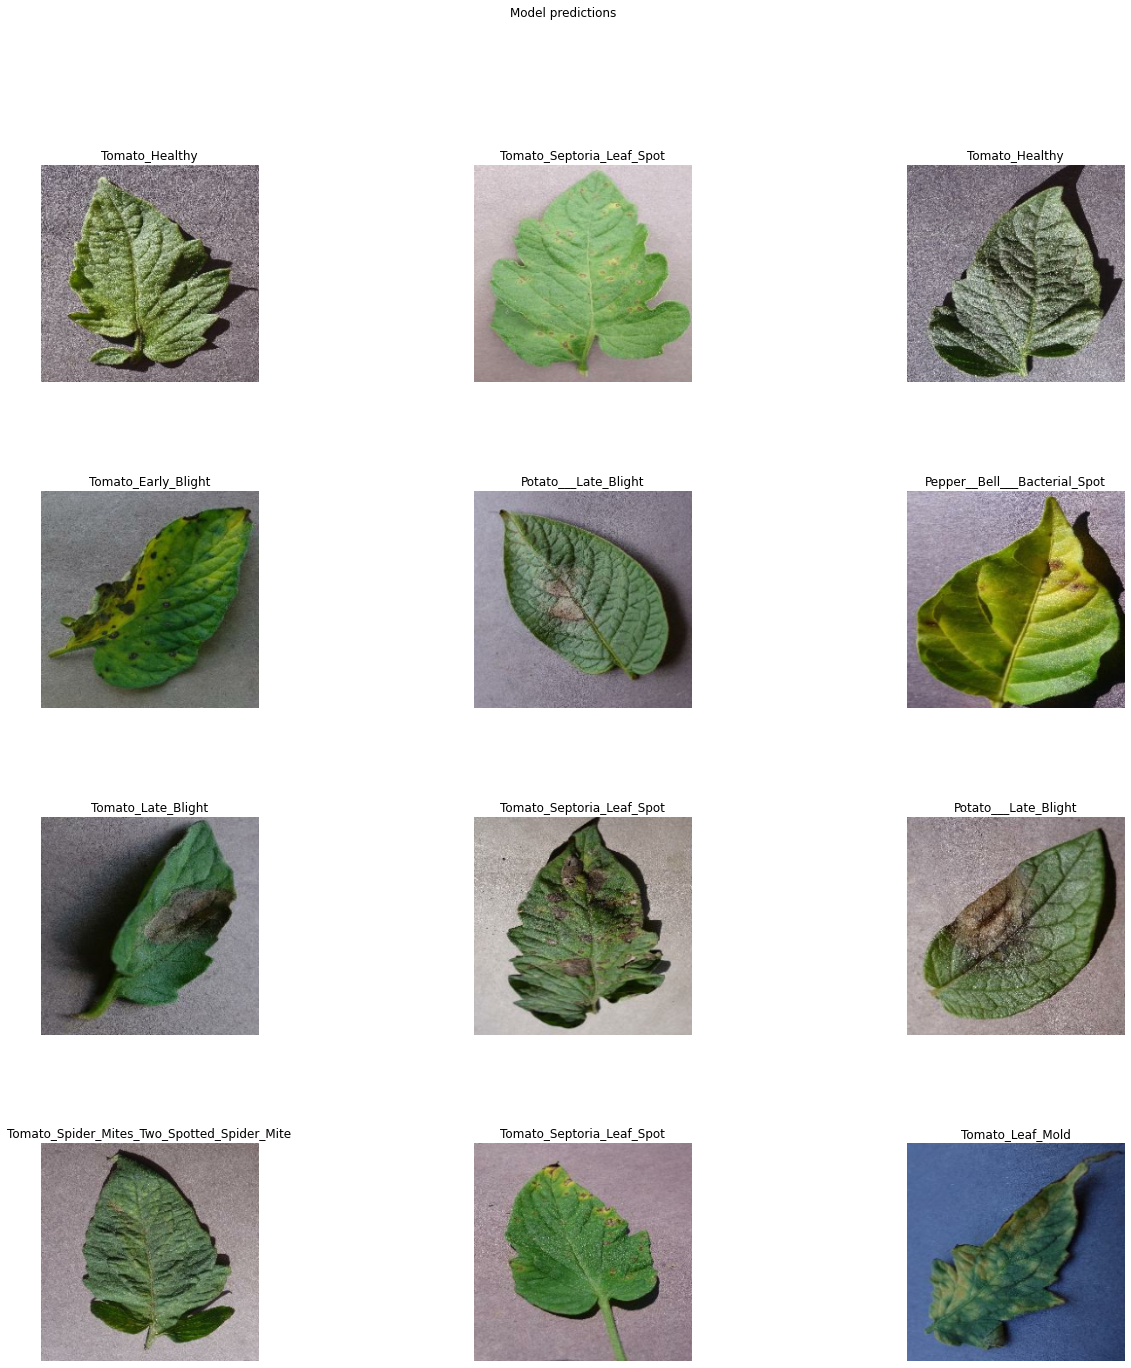

In [37]:
plt.figure(figsize=(22,22))
plt.subplots_adjust(hspace=0.5)

for n in range(12):
  plt.subplot(4,3,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")

### Confusion Matrix

In [38]:
for test_batch, test_labels_batch in test_ds:
    print(test_batch.shape)
    print(test_labels_batch.shape)
    break

(32, 224, 224, 3)
(32,)


In [39]:
test_batch

<tf.Tensor: shape=(32, 224, 224, 3), dtype=float32, numpy=
array([[[[0.6145458 , 0.5831733 , 0.57140857],
         [0.64825934, 0.6168868 , 0.6051221 ],
         [0.63521415, 0.6038416 , 0.5920769 ],
         ...,
         [0.534956  , 0.50358343, 0.49574032],
         [0.5613242 , 0.52995163, 0.5221085 ],
         [0.5702085 , 0.53883594, 0.5309928 ]],

        [[0.71700686, 0.6856343 , 0.6738696 ],
         [0.72350943, 0.6921369 , 0.6803722 ],
         [0.6856543 , 0.65428174, 0.64251703],
         ...,
         [0.42196715, 0.3905946 , 0.38275146],
         [0.5390571 , 0.5076845 , 0.49984142],
         [0.561024  , 0.52965146, 0.5218083 ]],

        [[0.69457793, 0.6632053 , 0.6514406 ],
         [0.64635855, 0.614986  , 0.6032213 ],
         [0.63699484, 0.6056223 , 0.5938576 ],
         ...,
         [0.5606852 , 0.5293127 , 0.52146953],
         [0.56260484, 0.5312323 , 0.52338916],
         [0.5622251 , 0.5308525 , 0.52300936]],

        ...,

        [[0.5641862 , 0.5288921 ,

In [40]:
predicted_batch = model.predict(test_ds)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
print(predicted_label_batch)
print(predicted_batch.shape)

38/38 [==============================] - 42s 1s/step
['Tomato_Septoria_leaf_spot' 'Tomato_Early_blight'
 'Pepper__bell___healthy' ... 'Pepper__bell___Bacterial_spot'
 'Tomato_Leaf_Mold' 'Tomato_Late_blight']
(1216, 15)


In [41]:
predicted_label_batch

array(['Tomato_Septoria_leaf_spot', 'Tomato_Early_blight',
       'Pepper__bell___healthy', ..., 'Pepper__bell___Bacterial_spot',
       'Tomato_Leaf_Mold', 'Tomato_Late_blight'], dtype='<U43')

In [42]:
test_label = np.concatenate([y for x, y in test_ds], axis=0)

In [43]:
cm = tf.math.confusion_matrix(labels=test_label, predictions=predicted_id)
cm

<tf.Tensor: shape=(15, 15), dtype=int32, numpy=
array([[ 67,   4,   0,   1,   0,   0,   0,   1,   0,   1,   0,   0,   0,
          0,   0],
       [  4,  75,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,  53,   3,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,  48,   0,   0,   0,   1,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   1,   0,   6,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0, 104,   0,   0,   0,  10,   0,   2,   1,
          0,   1],
       [  0,   0,   0,   0,   0,   2,  26,   8,   0,  12,   4,   2,   0,
          0,   0],
       [  0,   0,   0,   1,   0,   2,   0, 124,   1,   6,   0,   1,   0,
          0,   1],
       [  0,   0,   0,   0,   0,   0,   0,   2,  43,   6,   3,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   3,   1,   1,   0,  96,   0,   2,   0,
          0,   0],
       [  0,   0,   0,   0,   0,

Text(114.0, 0.5, 'Truth')

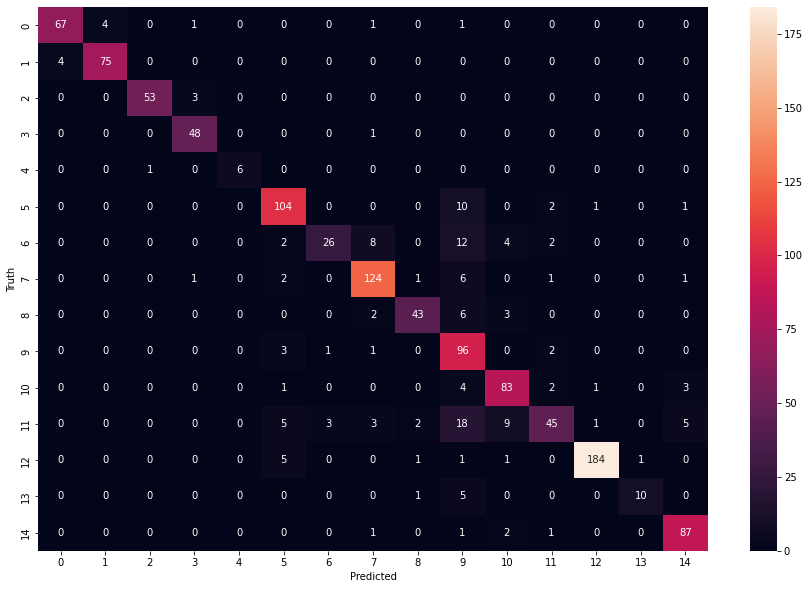

In [44]:
import seaborn as sn
plt.figure(figsize = (15,10))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

### Training Accuracy vs Loss & Validation Accuracy vs Loss

In [45]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

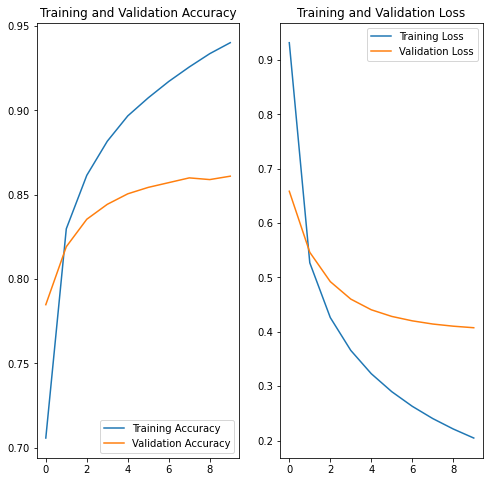

In [46]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(NUM_EPOCHS), acc, label='Training Accuracy')
plt.plot(range(NUM_EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(NUM_EPOCHS), loss, label='Training Loss')
plt.plot(range(NUM_EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Prediction on test images

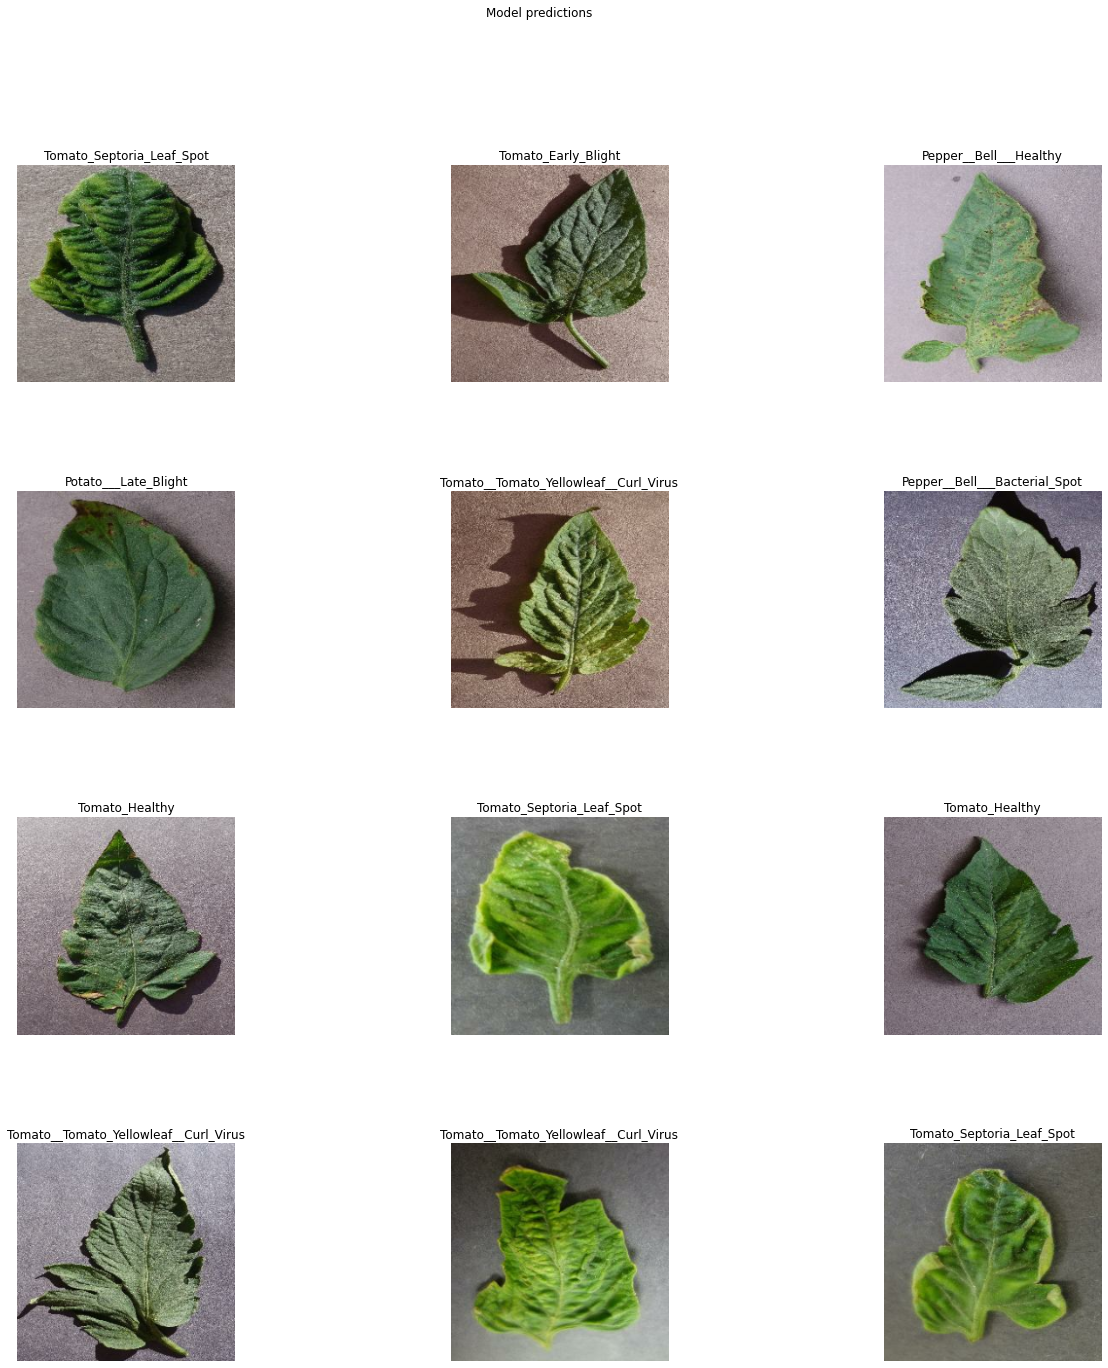

In [47]:
plt.figure(figsize=(22,22))
plt.subplots_adjust(hspace=0.5)

for n in range(12):
  plt.subplot(4,3,n+1)
  plt.imshow(test_batch[n])
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
  plt.suptitle("Model predictions")

### Prediction on Single Image

In [48]:
path=r'multi-plant-disease-dataset\\Tomato_Early_blight\0db67be3-f733-4d15-b7d9-5d075b2cafc7___RS_Erly.B 6401.JPG'
img = cv2.imread(path)
resized_img = cv2.resize(img,(224,224))
resized_img = np.expand_dims(resized_img, axis=0)

In [49]:
resized_img = np.array(resized_img)/255.0
resized_img.shape

(1, 224, 224, 3)

In [50]:
prr= model.predict(resized_img)

1/1 [==============================] - 1s 726ms/step


In [51]:
prr=np.argmax(prr)
prr

6

In [52]:
print(class_names[prr])

Tomato_Early_blight


Actual Label: Tomato_Early_blight
Predicted Label:  Tomato_Early_blight


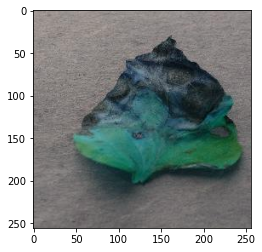

In [53]:
plt.imshow(img)
print('Actual Label: Tomato_Early_blight');
print('Predicted Label: ', class_names[prr]);

### Model Save

In [55]:
save_path = 'saved_models/multi_plat_disease_model_by_inception_v3.h5';

In [56]:
model.save(save_path)

In [57]:
my_reloaded_model = tf.keras.models.load_model(
       (save_path),
       custom_objects={'KerasLayer':hub.KerasLayer}
)

In [58]:
my_reloaded_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 2048)              21802784  
                                                                 
 dense (Dense)               (None, 15)                30735     
                                                                 
Total params: 21,833,519
Trainable params: 30,735
Non-trainable params: 21,802,784
_________________________________________________________________
